In [1]:
import warnings
warnings.filterwarnings('ignore')
import torch, torch.nn as nn, torch.nn.functional as F, torch.autograd as autograd, torch.optim as optim
import numpy as np, numpy.random as npr, matplotlib.pyplot as plt, matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
from samplers import *
from time import time
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline  

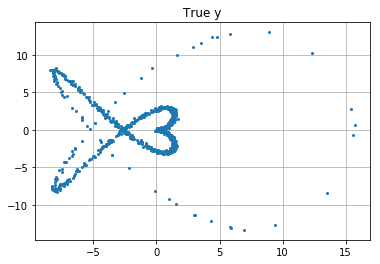

In [2]:
error_sigma = 1e-1
nobs = 1_000
xtrue = torch.randn(nobs, 1, requires_grad=True)
xvals = xtrue.data
ytrue = np.zeros((nobs, 2))
ytrue[:,0] = list(abs(xvals)*np.cos(2*xvals))
ytrue[:,1] = list(abs(xvals)*np.sin(3*xvals))
ytrue = 5*torch.from_numpy(ytrue).float() + torch.randn(nobs,2)*error_sigma
criterion = nn.MSELoss()
plt.plot(list(ytrue[:,0]), list(ytrue[:,1]), 'o', markersize=2)
plt.grid(True)
plt.title("True y");

In [3]:
mb_size = nobs
Z_dim = 1
X_dim = np.shape(ytrue)[1]
h_dim = 32
c = 0
lr = 1e-3

In [4]:
my_model = inout_model(X_dim, h_dim, Z_dim)
my_model.initialise()

T = 10_000
samples = torch.zeros(T, np.shape(ytrue)[1])
start = time()
for it in range(T) :
    mb = npr.choice(nobs, mb_size, replace=False)
    X_mb = Variable(ytrue[mb]).float()
    z_mu, z_var = my_model.Q(X_mb) # forward
    z_sample = my_model.sample_z(z_mu, z_var, mb_size)
    X_sample = my_model.P(z_sample)
    samples[it] = X_sample[npr.choice(np.shape(X_sample)[0])]
    
    recon_loss = nn.MSELoss()(X_mb, X_sample)
    kl_loss = torch.mean(0.5*torch.sum(torch.exp(z_var) + z_mu**2 - 1. - z_var, 1))
    loss = kl_loss + recon_loss

    my_model.solve(loss, lr)
    # Housekeeping
    my_model.housekeeping()

    if (it+1) % (T/10) == 0:
        print("Iter: %d; loss: %.2f; time: %.1f sec" % (it+1, loss.data, time()-start))

Iter: 1000; loss: 4.63; time: 3.0 sec
Iter: 2000; loss: 4.16; time: 5.7 sec
Iter: 3000; loss: 4.03; time: 8.4 sec
Iter: 4000; loss: 3.92; time: 11.1 sec
Iter: 5000; loss: 3.84; time: 13.8 sec
Iter: 6000; loss: 3.75; time: 16.6 sec
Iter: 7000; loss: 3.70; time: 19.3 sec
Iter: 8000; loss: 3.61; time: 22.0 sec
Iter: 9000; loss: 3.56; time: 24.7 sec
Iter: 10000; loss: 3.47; time: 27.5 sec


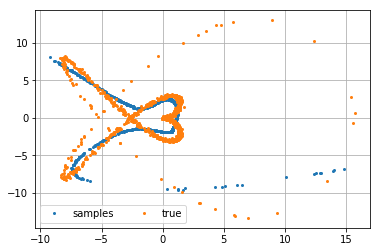

In [5]:
plt.grid(True)
plt.plot(list(samples[9_000::,0]), list(samples[9_000::,1]), 'o', markersize=2, label="samples")
plt.plot(list(ytrue[:,0]), list(ytrue[:,1]), 'o', markersize=2, label="true")
plt.legend(ncol=2)

In [6]:
nn_model = nn.Sequential(nn.Linear(1, h_dim),
                         nn.Tanh(),
                         nn.Linear(h_dim, 2))
init_normal(nn_model)

In [7]:
nn_model[0].weight.data = torch.transpose(my_model.Wzh.data,0,1)
nn_model[0].bias.data = my_model.bzh.data
nn_model[2].weight.data = torch.transpose(my_model.Whx.data,0,1)
nn_model[2].bias.data = my_model.bhx.data
print(nn_model)

Sequential(
  (0): Linear(in_features=1, out_features=32, bias=True)
  (1): Tanh()
  (2): Linear(in_features=32, out_features=2, bias=True)
)


In [8]:
x = torch.zeros(z_sample.size(), requires_grad=True)
x.data = z_sample.data

In [9]:
prior_sigma = 1e0
my_nn_model = model(deepcopy(x), deepcopy(ytrue), prior_sigma, error_sigma, deepcopy(nn_model))

In [10]:
Nsteps = 500
n_leapfrog = 150
stepsize = 2e-3
hmc = HMC(my_nn_model, Nsteps, stepsize, n_leapfrog)

In [11]:
hmc.run()

iter 50/500 after 0.34 min | accept_rate 0.0 percent | MSE loss nan
iter 100/500 after 0.68 min | accept_rate 0.0 percent | MSE loss nan
iter 150/500 after 1.02 min | accept_rate 0.0 percent | MSE loss nan
iter 200/500 after 1.35 min | accept_rate 0.0 percent | MSE loss nan
iter 250/500 after 1.68 min | accept_rate 0.0 percent | MSE loss nan
iter 300/500 after 2.01 min | accept_rate 0.0 percent | MSE loss nan
iter 350/500 after 2.34 min | accept_rate 0.0 percent | MSE loss nan
iter 400/500 after 2.68 min | accept_rate 0.0 percent | MSE loss nan
iter 450/500 after 3.02 min | accept_rate 0.0 percent | MSE loss nan
iter 500/500 after 3.35 min | accept_rate 0.0 percent | MSE loss nan


In [ ]:
ypred_final = hmc.my_nn_model.nn_model(hmc.my_nn_model.x)
plt.plot(ypred_final[:,0].data.numpy(), ypred_final[:,1].data.numpy(), 'o', markersize=2, label="HMC final")
plt.plot(ytrue[:,0].data.numpy(), ytrue[:,1].data.numpy(), 'o', markersize=2, label="true")
plt.grid(True)
plt.legend(ncol=2);